#### From https://pytorch.org/tutorials/beginner/knowledge_distillation_tutorial.html

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
transforms_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms_cifar)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms_cifar)

Files already downloaded and verified
Files already downloaded and verified


In [20]:
# Dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

In [69]:
class Teacher(nn.Module):
    def __init__(self, num_classes = 10):
        super(Teacher, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
class Student(nn.Module):
    def __init__(self, num_classes=10):
        super(Student, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [34]:
def train(model, train_loader, epochs, learning_rate, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            # inputs: A collection of batch_size images
            # labels: A vector of dimensionality batch_size with integers denoting class of each image
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)


            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")

def test(model, test_loader, device):
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

In [70]:
torch.manual_seed(42)
nn_deep = Teacher(num_classes=10).to(device)
train(nn_deep, train_loader, epochs=10, learning_rate=0.001, device=device)
test_accuracy_deep = test(nn_deep, test_loader, device)

# Instantiate the lightweight network:
torch.manual_seed(42)
nn_light = Student(num_classes=10).to(device)

Epoch 1/10, Loss: 1.3367099393054347
Epoch 2/10, Loss: 0.8756879732736846
Epoch 3/10, Loss: 0.6972364585875245
Epoch 4/10, Loss: 0.5502959078992419
Epoch 5/10, Loss: 0.43059593023698955
Epoch 6/10, Loss: 0.3233621587305118
Epoch 7/10, Loss: 0.23596385226149083
Epoch 8/10, Loss: 0.18377368192157478
Epoch 9/10, Loss: 0.1515025682461536
Epoch 10/10, Loss: 0.12625930000029867
Test Accuracy: 74.38%


In [36]:
torch.manual_seed(42)
new_nn_light = Student(num_classes=10).to(device)

In [37]:
total_params_deep = "{:,}".format(sum(p.numel() for p in nn_deep.parameters()))
print(f"DeepNN parameters: {total_params_deep}")
total_params_light = "{:,}".format(sum(p.numel() for p in nn_light.parameters()))
print(f"LightNN parameters: {total_params_light}")

DeepNN parameters: 1,777,194
LightNN parameters: 267,738


In [38]:
train(nn_light, train_loader, epochs=10, learning_rate=0.001, device=device)
test_accuracy_light_ce = test(nn_light, test_loader, device)

Epoch 1/10, Loss: 1.4690075234683884
Epoch 2/10, Loss: 1.1558701333487431
Epoch 3/10, Loss: 1.0248567614409014
Epoch 4/10, Loss: 0.9237221447403169
Epoch 5/10, Loss: 0.8495774590755667
Epoch 6/10, Loss: 0.7815079827747686
Epoch 7/10, Loss: 0.7173148143626845
Epoch 8/10, Loss: 0.6589951942796293
Epoch 9/10, Loss: 0.6076528542029583
Epoch 10/10, Loss: 0.5586857276651865
Test Accuracy: 70.42%


#### Knowledge distillation 시작

In [ ]:
def train_knowledge_distillation(teacher, student, train_loader, epochs, learning_rate, T, soft_target_loss_weight, ce_loss_weight, device):
    ce_loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    teacher.eval()  # Teacher set to evaluation mode
    student.train() # Student to train mode

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.no_grad():
                teacher_logits = teacher(inputs)
            student_logits = student(inputs)
            soft_targets = nn.functional.softmax(teacher_logits / T, dim=-1)
            # KL-Divergence에서 log_softmax값이 필요하므로 미리 적용
            soft_prob = nn.functional.log_softmax(student_logits / T, dim=-1)

            # KL-Divergence(student분포가 teacher를 따라가도록)
            soft_targets_loss = torch.sum(soft_targets * (soft_targets.log() - soft_prob)) / soft_prob.size()[0] * (T**2)

            # Calculate the true label loss
            label_loss = ce_loss(student_logits, labels)

            # Weighted sum of the two losses
            loss = soft_target_loss_weight * soft_targets_loss + ce_loss_weight * label_loss
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")

train_knowledge_distillation(teacher=nn_deep, student=new_nn_light, train_loader=train_loader, epochs=10, learning_rate=0.001, T=3, soft_target_loss_weight=0.25, ce_loss_weight=0.75, device=device)
test_accuracy_light_ce_and_kd = test(new_nn_light, test_loader, device)


print(f"Teacher accuracy: {test_accuracy_deep:.2f}%")
print(f"Student accuracy without teacher: {test_accuracy_light_ce:.2f}%")
print(f"Student accuracy with CE + KD: {test_accuracy_light_ce_and_kd:.2f}%")

Epoch 1/10, Loss: 1.1791530730169448
Epoch 2/10, Loss: 1.0846781585832386
Epoch 3/10, Loss: 1.0244933718915485
Epoch 4/10, Loss: 0.9661935830055295
Epoch 5/10, Loss: 0.9249031171774316
Epoch 6/10, Loss: 0.8744104353668135
Epoch 7/10, Loss: 0.8396243561259316
Epoch 8/10, Loss: 0.7971180456373698
Epoch 9/10, Loss: 0.762427858989257
Epoch 10/10, Loss: 0.7311158655854442
Test Accuracy: 70.92%
Teacher accuracy: 72.76%
Student accuracy without teacher: 70.42%
Student accuracy with CE + KD: 70.92%


#### Output이 아닌 Flatten 부분에서 distillation

CosineEmbeddingLoss

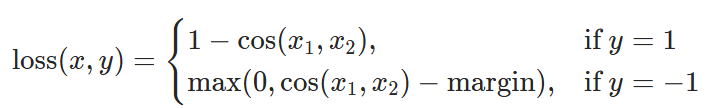


- class가 같을 경우 (1 - cosin similarity) 를 통해 input tensor를 서로 가깝게 만듦

- class가 다를 경우 cosine similarity를 margin 이하로 만듦

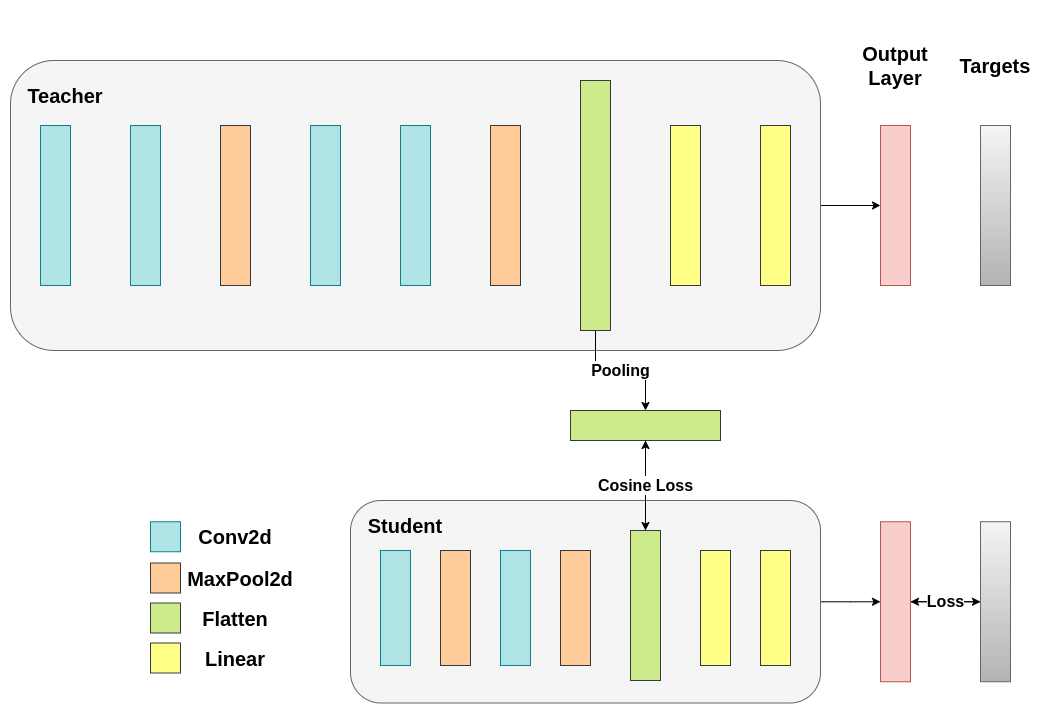

In [ ]:
class Teacher2(nn.Module):
    def __init__(self, num_classes = 10):
        super(Teacher2, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        flattened_conv_output = torch.flatten(x, 1)
        x = self.classifier(flattened_conv_output)
        flattened_conv_output_after_pooling = torch.nn.functional.avg_pool1d(flattened_conv_output, 2)
        return x, flattened_conv_output_after_pooling
    
class Student2(nn.Module):
    def __init__(self, num_classes=10):
        super(Student2, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        flattened_conv_output = torch.flatten(x, 1)
        x = self.classifier(flattened_conv_output)
        return x, flattened_conv_output

modified_nn_deep = Teacher2(num_classes=10).to(device)
modified_nn_deep.load_state_dict(nn_deep.state_dict())


print("Norm of 1st layer for deep_nn:", torch.norm(nn_deep.features[0].weight).item())
print("Norm of 1st layer for modified_deep_nn:", torch.norm(modified_nn_deep.features[0].weight).item())

# Initialize a modified lightweight network with the same seed as our other lightweight instances. This will be trained from scratch to examine the effectiveness of cosine loss minimization.
torch.manual_seed(42)
modified_nn_light = Student2(num_classes=10).to(device)
print("Norm of 1st layer:", torch.norm(modified_nn_light.features[0].weight).item())

Norm of 1st layer for deep_nn: 7.095464706420898
Norm of 1st layer for modified_deep_nn: 7.095464706420898
Norm of 1st layer: 2.327361822128296


In [53]:
# Create a sample input tensor
sample_input = torch.randn(128, 3, 32, 32).to(device) # Batch size: 128, Filters: 3, Image size: 32x32

# Pass the input through the student
logits, hidden_representation = modified_nn_light(sample_input)

# Print the shapes of the tensors
print("Student logits shape:", logits.shape) # batch_size x total_classes
print("Student hidden representation shape:", hidden_representation.shape) # batch_size x hidden_representation_size

# Pass the input through the teacher
logits, hidden_representation = modified_nn_deep(sample_input)

# Print the shapes of the tensors
print("Teacher logits shape:", logits.shape) # batch_size x total_classes
print("Teacher hidden representation shape:", hidden_representation.shape) # batch_size x hidden_representation_size

Student logits shape: torch.Size([128, 10])
Student hidden representation shape: torch.Size([128, 1024])
Teacher logits shape: torch.Size([128, 10])
Teacher hidden representation shape: torch.Size([128, 1024])


In [54]:
def train_cosine_loss(teacher, student, train_loader, epochs, learning_rate, hidden_rep_loss_weight, ce_loss_weight, device):
    ce_loss = nn.CrossEntropyLoss()
    cosine_loss = nn.CosineEmbeddingLoss()
    optimizer = optim.Adam(student.parameters(), lr = learning_rate)

    teacher.to(device)
    student.to(device)
    teacher.eval()
    student.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            with torch.no_grad():
                _, teacher_hidden_representation = teacher(inputs)

            # Forward pass with the student model
            student_logits, student_hidden_representation = student(inputs)

            hidden_rep_loss = cosine_loss(student_hidden_representation, teacher_hidden_representation, target=torch.ones(inputs.size(0)).to(device))
            label_loss = ce_loss(student_logits, labels)

            loss = hidden_rep_loss_weight * hidden_rep_loss + ce_loss_weight * label_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")

In [55]:
def test_multiple_outputs(model, test_loader, device):
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs, _ = model(inputs) # Disregard the second tensor of the tuple
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

In [57]:
# Train and test the lightweight network with cross entropy loss
train_cosine_loss(teacher=modified_nn_deep, student=modified_nn_light, train_loader=train_loader, epochs=10, learning_rate=0.001, hidden_rep_loss_weight=0.25, ce_loss_weight=0.75, device=device)
test_accuracy_light_ce_and_cosine_loss = test_multiple_outputs(modified_nn_light, test_loader, device)

Epoch 1/10, Loss: 0.612385806144046
Epoch 2/10, Loss: 0.580096672181888
Epoch 3/10, Loss: 0.5563056603112184
Epoch 4/10, Loss: 0.5310544000409753
Epoch 5/10, Loss: 0.5087588688601619
Epoch 6/10, Loss: 0.48525123721193475
Epoch 7/10, Loss: 0.4671599829898161
Epoch 8/10, Loss: 0.4446844461628848
Epoch 9/10, Loss: 0.4274260969570531
Epoch 10/10, Loss: 0.4172014008702524
Test Accuracy: 71.50%
Student accuracy without teacher: 70.42%


In [58]:
print(f"Teacher accuracy: {test_accuracy_deep:.2f}%")
print(f"Student accuracy without teacher: {test_accuracy_light_ce:.2f}%")
print(f"Student accuracy with CE + KD: {test_accuracy_light_ce_and_kd:.2f}%")
print(f"Student accuracy with CE + CosineLoss: {test_accuracy_light_ce_and_cosine_loss:.2f}%")

Teacher accuracy: 72.76%
Student accuracy without teacher: 70.42%
Student accuracy with CE + KD: 70.92%
Student accuracy with CE + CosineLoss: 71.50%


#### Extra conv를 추가하여 Teacher와 비교

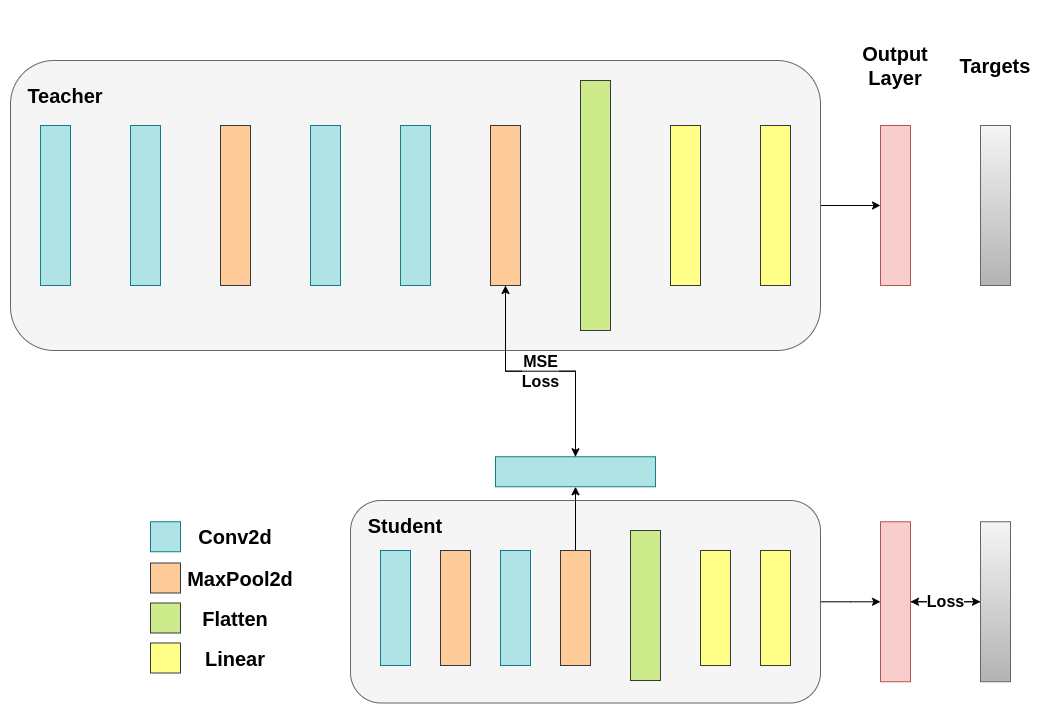

In [65]:
class Teacher3(nn.Module):
    def __init__(self, num_classes = 10):
        super(Teacher3, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        conv_feature_map = x
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x, conv_feature_map
    

class Student3(nn.Module):
    def __init__(self, num_classes = 10):
        super(Student3, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # Include an extra regressor (in our case linear)
        self.regressor = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        regressor_output = self.regressor(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x, regressor_output

In [71]:
def train_mse_loss(teacher, student, train_loader, epochs, learning_rate, feature_map_weight, ce_loss_weight, device):
    ce_loss = nn.CrossEntropyLoss()
    mse_loss = nn.MSELoss()
    optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    teacher.to(device)
    student.to(device)
    teacher.eval()  # Teacher set to evaluation mode
    student.train() # Student to train mode

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Again ignore teacher logits
            with torch.no_grad():
                _, teacher_feature_map = teacher(inputs)

            # Forward pass with the student model
            student_logits, regressor_feature_map = student(inputs)

            # Calculate the loss
            hidden_rep_loss = mse_loss(regressor_feature_map, teacher_feature_map)

            # Calculate the true label loss
            label_loss = ce_loss(student_logits, labels)

            # Weighted sum of the two losses
            loss = feature_map_weight * hidden_rep_loss + ce_loss_weight * label_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")

# Initialize a ModifiedLightNNRegressor
torch.manual_seed(42)
modified_nn_light_reg = Student3(num_classes=10).to(device)


modified_nn_deep_reg = Teacher3(num_classes=10).to(device)
modified_nn_deep_reg.load_state_dict(nn_deep.state_dict())

# Train and test once again
train_mse_loss(teacher=modified_nn_deep_reg, student=modified_nn_light_reg, train_loader=train_loader, epochs=10, learning_rate=0.001, feature_map_weight=0.25, ce_loss_weight=0.75, device=device)

test_accuracy_light_ce_and_mse_loss = test_multiple_outputs(modified_nn_light_reg, test_loader, device)

Epoch 1/10, Loss: 1.785096633159901
Epoch 2/10, Loss: 1.3811141703744678
Epoch 3/10, Loss: 1.2309930324554443
Epoch 4/10, Loss: 1.1301610114629312
Epoch 5/10, Loss: 1.0520982942007997
Epoch 6/10, Loss: 0.9908113113754545
Epoch 7/10, Loss: 0.9362153569450768
Epoch 8/10, Loss: 0.8842480859488172
Epoch 9/10, Loss: 0.8451845566634937
Epoch 10/10, Loss: 0.8047255423977552
Test Accuracy: 70.23%
